### 북 리커맨드 레터 만들기



In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

In [5]:
import requests
import os

NAVER_CLIENT_ID = os.getenv("NAVER_CLIENT_ID")
NAVER_CLIENT_SECRET = os.getenv("NAVER_CLIENT_SECRET")

def search_for_book_titles(keyword):
    """
    This tool interacts with the Naver Book Search API to search for recent book titles related to a given keyword.

    Args:
        keyword (str): The keyword or phrase to search for in the books.

    Returns:
        list of str: A list of up to 5 book titles related to the keyword.
    """
    url = "https://openapi.naver.com/v1/search/book.json"
    headers = {
        "X-Naver-Client-Id": NAVER_CLIENT_ID,
        "X-Naver-Client-Secret": NAVER_CLIENT_SECRET,
    }
    params = {
        "query": keyword,
        "display": 5,     # 최대 5개 결과
        "sort": "sim"    # 최신순 정렬
    }

    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()  # 오류 발생 시 예외

    items = response.json().get("items", [])
    title_list = [item["title"].replace("<b>", "").replace("</b>", "") for item in items]

    return title_list


In [8]:
# test
keyword = "김금희"
result = search_for_book_titles(keyword)
print(result)

['대온실 수리 보고서 (김금희 장편소설)', '나의 폴라 일지(큰글자도서)', '대온실 수리 보고서 (큰글자도서) (김금희 장편소설)', '나의 폴라 일지', '敬愛の心']


In [22]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Data model
class BookLetterThemeOutput(BaseModel):
    """Output model for structured theme and sub-theme generation."""

    theme: str = Field(
        description="The main book letter theme based on the provided books titles."
    )
    sub_themes: list[str] = Field(
        description="List of sub-themes or key books items to investigate under the main theme, ensuring they are specific and researchable."
    )


# LLM with function call
structured_llm_book_letter = llm.with_structured_output(BookLetterThemeOutput)

# Prompt
system = """
You are an expert in crafting engaging and insightful book letters.

Based on the provided book titles, your task is to:
- Identify one main theme, written as a specific and intriguing question that would capture readers' attention.
- Generate five highly specific and researchable sub-themes related to the main theme, focused on emerging trends, technologies, or key insights.

Avoid broad or generic topics. The sub-themes should guide the direction of the book letter with clarity and depth.

All output must be written in Korean.

"""

# This is the template that will feed into the structured LLM
theme_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Book titles: \n\n {book_titles}"),
    ]
)

# Chain together the system prompt and the structured output model
book_letter_generator = theme_prompt | structured_llm_book_letter

In [29]:
# test
output = book_letter_generator.invoke({"book_titles": result})
sub_themes = output.sub_themes
output

BookLetterThemeOutput(theme='눈물은 인간 감정의 거울일까?', sub_themes=['눈물의 생리학적 기능: 심리적 자극에 따른 눈물의 종류와 성분', '사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상', '눈물과 스트레스: 심리적 고통이 신체에 미치는 영향', '눈물의 진화론적 관점: 눈물의 발생과 인류 역사 속 의미 변화', '기술 발전이 눈물 분석에 미친 영향: AI와 생체인식 기술을 통한 감정 이해'])

In [73]:
import asyncio
from typing import Dict, List, TypedDict, Annotated
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import operator
from tavily import TavilyClient, AsyncTavilyClient
import os

# 딕셔너리 형태의 값들을 계속해서 누적해 나가기 위한 함수
# 왼, 오른 모두 Dict 인 경우, 이 둘을 함쳐서 하나의 Dict 으로 정의
def merge_dicts(left: Dict, right:Dict) -> Dict:
    return {**left, **right}

class State(TypedDict):
    keyword: str
    book_titles: List[str]
    book_letter_theme: BookLetterThemeOutput
    sub_theme_books: Dict[str, List[Dict]]
    results: Annotated[Dict[str, str], merge_dicts]
    messages : Annotated[List, add_messages]


# 동기 함수들
# 주어진 키워드를 기반으로 관련된 책 제목을 뽑아주는 함수
def search_keyword(state: State) -> State:
    keyword = state['keyword']
    book_titles = search_for_book_titles(keyword)
    return {"book_titles": book_titles}


# book_titles 기반으로 북 레터의 대, 소주제를 정의
def generated_book_letter_theme(state: State) -> State:
    book_titles = state['book_titles']
    book_letter_theme = book_letter_generator.invoke({"book_titles": "\n".join(book_titles)})
    book_letter_theme.sub_themes = book_letter_theme.sub_themes[:5]
    return {"book_letter_theme": book_letter_theme}


# 각각의 세부 주제들에 대해서 비동기로 검색을 실행
# asyncio.gather 비동기로 한꺼번에 모아 실행
async def search_sub_themes(state: State) -> State:
    sub_themes = state['book_letter_theme'].sub_themes
    results = await asyncio.gather(*[search_sub_theme(sub_theme) for sub_theme in sub_themes])

    sub_theme_books = {}
    for result in results:
        sub_theme_books.update(result)

    return {"sub_theme_books": sub_theme_books}


# 비동기로 실행하는 Tavily 검색
# 세부 주제에 대해서 비동기로 북 검색
# sub_theme 에 대한 book letter info 저장함
async def search_sub_theme(sub_theme):
    async_tavily_client = AsyncTavilyClient()
    response = await async_tavily_client.search(
        query=sub_theme,
        max_results=3,
        topic="general",
        days=100,
        include_images=True,
        include_raw_content=True)
    images = response['images']
    results = response['results']

    book_letter_info = []
    for i, result in enumerate(results):
        book_letter_info.append({
            'title': result['title'],
            'image_url': images[i],
            'raw_content': result['raw_content'],
        })
    return {sub_theme : book_letter_info}


# 검색 후 세부 주제 본문 작성
def write_book_letter_section(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_book_letter_section_async(state, sub_theme))

async def write_book_letter_section_async(state: State, sub_theme: str) -> Dict:
    books = state['sub_theme_books'][sub_theme]

    #Prepare a list of formatted book references including title, image, and a snippet of raw content
    books_references = "\n".join(
        [f"Title: {book['title']}\nContent: {book['raw_content']}..." for book in books]
    )

    prompt = f"""
    Write a book letter section for the sub-theme: "{sub_theme}".

    Use the following books as reference and include relevant points from both their titles, images, and content:
    <book>
    {books_references}
    </book>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion.
    Keep the tone engaging and informative for book letter readers. You should write in Korean
    """

    messages = [HumanMessage(content=prompt)]
    response = await llm.ainvoke(messages)
    return {"results":{sub_theme: response.content}}

# 세부 주제들에 대해서 결합
def aggregate_results(state: State) -> State:
    theme = state['book_letter_theme'].theme
    combined_book_letter = f"# {theme}\n\n"
    for sub_theme, content in state['results'].items():
        combined_book_letter += f"# {sub_theme}\n{content}\n"
    return {"messages": [HumanMessage(content=f"Generated Book Letter:\n\n{combined_book_letter}")]}


def edit_book_letter(state: State) -> State:
    theme = state['book_letter_theme'].theme
    combined_book_letter = state['messages'][-1].content

    prompt = f"""
    As an expert editor, review and refine the following book letter on the theme: {theme}

    {combined_book_letter}

    Please ensure:
    0. Title should be in question form. subtitles are free to make question or just sentence.
    1. Consistent tone and style throughout the book letter.
    2. Smooth transitions between sections.
    3. Proper formatting and structure.
    4. Clear and engaging language.
    5. No grammatical or spelling errors.

    Provide the edited version of the book letter.
    """

    messages = [HumanMessage(content=prompt)]
    writer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=1, max_tokens = 8192)
    response = writer_llm.invoke(input=messages)

    return {"messages" :[HumanMessage(content=f"Edited Book Letter:\n\n{response.content}")]}


# LangGraph 구성
workflow = StateGraph(State)
workflow.add_node("editor", edit_book_letter)
workflow.add_node("search_keyword", search_keyword)
workflow.add_node("generated_theme", generated_book_letter_theme)
workflow.add_node("search_sub_themes", search_sub_themes)
workflow.add_node("aggregate", aggregate_results)

for i in range(5):
    node_name = f"write_section_{i}"
    workflow.add_node(node_name, lambda s, i=i: write_book_letter_section(s, s['book_letter_theme'].sub_themes[i]))

# 엣지 연결
workflow.add_edge(START, "search_keyword")
workflow.add_edge("search_keyword", "generated_theme")
workflow.add_edge("generated_theme", "search_sub_themes")
for i in range(5):
    workflow.add_edge("search_sub_themes", f"write_section_{i}")
    workflow.add_edge(f"write_section_{i}", "aggregate")
workflow.add_edge("aggregate", "editor")
workflow.add_edge("editor", END)

graph = workflow.compile()


In [74]:
keyword = input("Enter a keyword for the book letter")

inputs = {"keyword": keyword}
async for output in graph.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(print(value))
    print("\n---\n")

Output from node 'search_keyword':
---
{'book_titles': ['Geum Hee - Wikipedia', '김금희 (1979년) - 위키백과, 우리 모두의 백과사전', 'Kim Keum-hee - Wikipedia', '김금희 | 소설가 - 교보문고', '김금희 - 위키백과, 우리 모두의 백과사전', '대온실 수리 보고서(김금희) : 줄거리, 인물, 역사소설 후기 : 네이버 블로그', '김금희 (@keumhee_kim_hey) • Instagram photos and videos', '김금희 - 나무위키', '21이 사랑한 작가 김금희① "받지 않는 전화를 오래도록 겁니다"', "[책&생각] 김금희의 첫 팩션 '상처는 어떻게 미래가 되는가'"]}
None

---

Output from node 'generated_theme':
---
{'book_letter_theme': BookLetterThemeOutput(theme='김금희 작가의 작품과 그녀가 그려내는 현대 사회의 희망과 상처, 우리는 어떻게 극복할 수 있을까?', sub_themes=['김금희의 문학적 스타일과 주제 의식이 현대인의 정체성에 미치는 영향은 무엇인가?', '작품 속 인물들이 경험하는 심리적 상처와 회복의 과정은 어떻게 묘사되는가?', "21세기 문학에서 등장하는 '팩션'의 방식과 그 사회적 의미는 무엇인가?", '김금희의 작품에 나타나는 여성의 삶과 사회적 역할 변화는 어떻게 반영되고 있는가?', '김금희가 속한 문학적 전통과 그가 선택하는 소재의 정치적, 사회적 맥락은 무엇인가?'])}
None

---

Output from node 'search_sub_themes':
---
{'sub_theme_books': {'김금희의 문학적 스타일과 주제 의식이 현대인의 정체성에 미치는 영향은 무엇인가?': [{'title': "[신준봉의 '젊은 작가 列傳'(2)] 감수성 깊은 사랑의 관찰자, 소설가 김금희 - 월간중앙", 'image_url': 'ht

In [57]:
## test
import nest_asyncio
nest_asyncio.apply()

asyncio.run(search_sub_theme("사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상"))

{'눈물의 의미': [{'title': '눈물의 의미: 감정의 표현과 신체적 반응 - blogmina.com',
   'image_url': 'https://i.ytimg.com/vi/Lbt6qA-Otww/maxresdefault.jpg',
   'raw_content': 'Published Time: 2024-11-26T02:11:55+09:00\n눈물의 의미: 감정의 표현과 신체적 반응\nSkip to content\n간단설명\nMenu\nMenu\n\n정보\n\n눈물의 의미: 감정의 표현과 신체적 반응\n2024-11-26 by admin\n눈물은 인간이 감정적으로 혹은 신체적으로 반응할 때 자연스럽게 발생하는 액체입니다. 눈물은 단순히 눈에서 흘러내리는 물방울이 아니라, 감정, 스트레스, 신체적 반응 등 여러 가지 이유로 발생할 수 있습니다. 눈물은 사람의 감정 상태를 반영하는 중요한 지표로, 기쁨, 슬픔, 분노, 불안 등 다양한 감정을 표현하는 방법으로 사용됩니다. 이 글에서는 눈물의 정의, 종류, 발생 원인, 그리고 사회적, 생리적 의미에 대해 자세히 살펴보겠습니다.\n목차\n\n눈물의 정의\n기본 개념\n눈물의 주요 기능\n\n\n눈물의 종류\n1. 기본 눈물 (Basal Tears)\n2. 반사 눈물 (Reflex Tears)\n3. 감정 눈물 (Emotional Tears)\n4. 배설 눈물 (Lacrimal Tears)\n\n\n눈물이 발생하는 원인\n1. 감정적 원인\n2. 신체적 원인\n3. 스트레스와 해소\n\n\n눈물의 생리적 역할\n1. 눈 보호\n2. 감정 해소\n3. 의사소통의 수단\n\n\n사회적 의미\n1. 공감과 위로\n2. 연대와 소통\n\n\n결론\n\n눈물의 정의\n기본 개념\n눈물은 눈에서 분비되는 액체로, 보통 눈을 보호하고, 윤활을 제공하며, 감정적 반응에 따라 분비되기도 합니다. 눈물은 주로 눈물샘에서 생성되며, 눈을 보호하고 청소하는 역할을 합니다. 감정적인 상태나 외부 자극에 반응하여 눈물이 흐를 수 있습니다

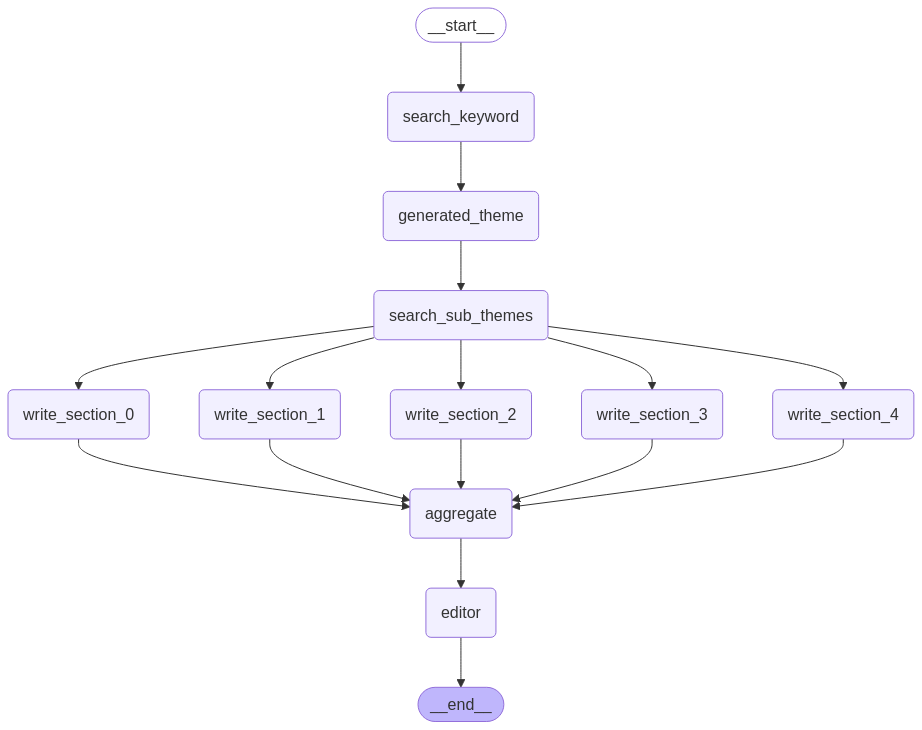

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
test_state = {
    'sub_theme_books': {
        '사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상': [
            {
                'title': '눈물의 의미: 감정의 표현과 신체적 반응 - blogmina.com',
                'raw_content': '''간단설명\n\n눈물의 의미: 감정의 표현과 신체적 반응\n\n눈물은 인간이 감정적으로 혹은 신체적으로 반응할 때 자연스럽게 발생하는 액체입니다. 눈물은 단순히 눈에서 흘러내리는 물방울이 아니라, 감정, 스트레스, 신체적 반응 등 여러 가지 이유로 발생할 수 있습니다. 눈물은 사람의 감정 상태를 반영하는 중요한 지표로, 기쁨, 슬픔, 분노, 불안 등 다양한 감정을 표현하는 방법으로 사용됩니다. 이 글에서는 눈물의 정의, 종류, 발생 원인, 그리고 사회적, 생리적 의미에 대해 자세히 살펴보겠습니다.\n\n목차\n\n눈물의 정의\n\n기본 개념\n\n눈물은 눈에서 분비되는 액체로, 보통 눈을 보호하고, 윤활을 제공하며, 감정적 반응에 따라 분비되기도 합니다. 눈물은 주로 눈물샘에서 생성되며, 눈을 보호하고 청소하는 역할을 합니다. 감정적인 상태나 외부 자극에 반응하여 눈물이 흐를 수 있습니다. 인간에게는 다른 동물들에 비해 더 복잡한 감정적 눈물이 있으며, 이는 우리의 심리적 상태와 깊은 연관이 있습니다.\n\n눈물의 주요 기능\n\n눈물의 종류\n\n눈물은 그 발생 원인에 따라 여러 종류로 나눌 수 있습니다. 각 눈물은 생리적, 감정적, 반사적 이유로 발생할 수 있습니다.\n\n1. 기본 눈물 (Basal Tears)\n\n2. 반사 눈물 (Reflex Tears)\n\n3. 감정 눈물 (Emotional Tears)\n\n4. 배설 눈물 (Lacrimal Tears)\n\n눈물이 발생하는 원인\n\n1. 감정적 원인\n\n눈물은 감정적인 상태에 따라 발생합니다. 예를 들어, 슬픔, 기쁨, 감동, 분노, 스트레스 등 다양한 감정은 눈물을 유발할 수 있습니다. 감정적인 눈물은 신체의 자연스러운 해소 수단으로 작용할 수 있으며, 감정의 발산과 해소에 기여합니다.\n\n2. 신체적 원인\n\n눈물은 신체적인 자극이나 상태에도 반응할 수 있습니다. 예를 들어, 외부 자극(연기, 자극적인 냄새 등)이나 눈의 건조함, 피로감 등은 눈물이 발생하게 만듭니다. 또한, 눈 질환이나 눈에 들어간 이물질도 눈물이 나는 원인이 될 수 있습니다.\n\n3. 스트레스와 해소\n\n스트레스가 쌓일 때 눈물이 흐를 수 있습니다. 스트레스가 지속되면 신체는 이를 해소하기 위해 감정적 눈물을 흘릴 수 있습니다. 이는 몸의 자연스러운 반응으로, 긴장을 풀고 감정을 해소하려는 메커니즘의 일환으로 이해할 수 있습니다.\n\n눈물의 생리적 역할\n\n1. 눈 보호\n\n눈물은 눈을 보호하는 중요한 역할을 합니다. 눈물은 눈의 표면을 덮어 이물질이 들어가지 않도록 막아주며, 눈의 건조함을 예방하고 윤활작용을 합니다. 또한, 눈물에는 항균 성분이 포함되어 있어 감염을 예방하는 데 도움이 됩니다.\n\n2. 감정 해소\n\n감정적 눈물은 심리적 스트레스나 고통을 해소하는 역할을 합니다. 연구에 따르면, 감정적으로 울 때 뇌에서 스트레스 호르몬인 코르티솔이 배출되며, 이로 인해 감정적인 안정이 찾아올 수 있습니다. 눈물은 감정을 해소하고 심리적 안정을 찾는 방법 중 하나로 작용합니다.\n\n3. 의사소통의 수단\n\n눈물은 비언어적 의사소통 수단으로도 사용됩니다. 누군가가 울고 있을 때, 그 사람의 감정 상태나 심리적 상태를 이해할 수 있기 때문에, 눈물은 타인과의 소통에서 중요한 역할을 합니다. 또한, 슬픔이나 기쁨을 나누는 데 중요한 감정적 연결고리가 됩니다.\n\n사회적 의미\n\n눈물은 사회적으로도 중요한 의미를 가집니다. 감정적 눈물은 인간의 본능적 반응이자, 사회적 상호작용에서 중요한 역할을 합니다.\n\n1. 공감과 위로\n\n눈물은 타인과의 공감을 촉진하는 중요한 요소입니다. 누군가가 슬프거나 감동적인 상황에 처했을 때 그들의 눈물을 보고 공감하거나 위로하는 것이 일반적인 사회적 행동입니다. 이는 인간의 사회적 본능에서 비롯된 것으로, 감정을 나누는 중요한 방법입니다.\n\n2. 연대와 소통\n\n눈물은 사람들 간의 연대감을 형성하는 데 중요한 역할을 합니다. 힘든 상황을 함께 겪은 사람들은 서로의 눈물을 이해하고, 이를 통해 더욱 깊은 유대감을 형성할 수 있습니다.\n\n결론\n\n눈물은 단순한 신체적 반응을 넘어서, 감정의 깊이를 나타내고, 사회적 관계를 더욱 강화하는 중요한 요소입니다. 눈물은 다양한 원인에 의해 발생하며, 그 목적은 눈을 보호하고, 감정을 해소하며, 사회적 상호작용을 돕는 것입니다. 감정적으로나 신체적으로 어려움을 겪을 때 흐르는 눈물은 우리에게 중요한 메시지를 전달하는 신호일 수 있으며, 이를 이해하는 것은 더 나은 사회적 관계를 만드는 데 기여할 수 있습니다.\n\n'''
            },
            {
                'title': '눈물의 역사와 문화적 의미 : 네이버 ... - 네이버 블로그',
                'raw_content': '''\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n프롤로그블로그 | 지도서재안부\n블로그\n\n\n\n |  | \n | 전체보기574개의 글전체보기목록열기 | \n전체보기 574개의 글\n\n |  | \n |  | \n | 게시판눈물의 역사와 문화적 의미함께하는 건강정보・2024. 5. 19. 19:54URL 복사이웃추가본문 기타 기능공유하기신고하기눈물의 역사와 문화적 의미\u200b인간의 눈물은 단순한 수분 덩어리가 아니라, 복잡하고 강력한 의사소통 수단으로 오랜 역사와 문화적 의미를 지니고 있습니다.\u200b고대 역사\u200b눈물은 인간 역사 전반에 걸쳐 다양한 방식으로 해석되었습니다. 고대 이집트인들은 눈물이 오시리스 신의 눈에서 흘러내리는 것으로 믿었는데, 이 눈물은 삶과 번성을 상징했습니다. 로마인들은 눈물을 감정 표현과 정화의 상징으로 사용했습니다.\u200b중세와 르네상스중세와 르네상스 시대에는 눈물이 종교적 열의와 참회의 표시로 여겨졌습니다. 성모 마리아와 성자들은 종종 눈물을 흘리는 모습으로 묘사되었는데, 이는 그들의 연민과 구속에 대한 갈망을 나타냅니다.\u200b17세기와 18세기\u200b17세기와 18세기의 낭만주의 운동은 눈물을 감성 표현의 필수적인 부분으로 강조했습니다. 시인과 작가들은 눈물을 슬픔과 연민뿐 아니라 기쁨과 경외심을 나타내는 수단으로 사용했습니다.\u200b현대 문화\u200b현대 문화에서 눈물은 여전히 감정 표현의 중요한 역할을 합니다. 그러나 문화에 따라 눈물을 보이는 것이 용납되는지 여부와 표현하는 방식에 차이가 있습니다. 서구 문화에서는 남성이 감정을 억제하는 것이 규범으로 여겨지지만, 동양 문화에서는 눈물을 표현하는 것이 더 받아들여집니다.\u200b문화 간의 차이\u200b눈물에 대한 문화 간의 차이는 종교적 믿음, 사회적 규범, 성별 역할 등 다양한 요인에 영향을 받습니다. 일부 문화에서는 눈물을 약함의 표시로 여기는 반면, 다른 문화에서는 눈물을 힘과 인간성의 표시로 여깁니다.\u200b눈물의 치유력\u200b최근 연구에 따르면 눈물에는 치유력이 있는 것으로 나타났습니다. 눈물에는 스트레스 호르몬인 코르티솔이 포함되어 있으며, 눈물을 흘리면 스트레스와 긴장을 줄이는 데 도움이 될 수 있습니다. 또한, 눈물에는 항균 성분이 포함되어 있으며, 감염으로부터 눈을 보호하는 데 도움이 될 수 있습니다.\u200b결론\u200b눈물은 인간 경험의 필수적인 부분입니다. 그것은 감정을 표현하고, 소통하며, 치유하는 수단으로 오랜 역사와 문화적 의미를 지니고 있습니다. 눈물에 대한 우리의 이해는 우리가 다른 문화를 인정하고, 인간의 다양성을 축하하는 데 도움이 될 수 있습니다.태그취소확인공감이 글에 공감한 블로거 열고 닫기댓글1이 글에 댓글 단 블로거 열고 닫기인쇄댓글쓰기1/1이전다음 | \n눈물의 역사와 문화적 의미\n\n눈물의 역사와 문화적 의미\n\n\u200b\n\n인간의 눈물은 단순한 수분 덩어리가 아니라, 복잡하고 강력한 의사소통 수단으로 오랜 역사와 문화적 의미를 지니고 있습니다.\n\n\u200b\n\n고대 역사\n\n\u200b\n\n눈물은 인간 역사 전반에 걸쳐 다양한 방식으로 해석되었습니다. 고대 이집트인들은 눈물이 오시리스 신의 눈에서 흘러내리는 것으로 믿었는데, 이 눈물은 삶과 번성을 상징했습니다. 로마인들은 눈물을 감정 표현과 정화의 상징으로 사용했습니다.\n\n\u200b\n\n중세와 르네상스\n\n중세와 르네상스 시대에는 눈물이 종교적 열의와 참회의 표시로 여겨졌습니다. 성모 마리아와 성자들은 종종 눈물을 흘리는 모습으로 묘사되었는데, 이는 그들의 연민과 구속에 대한 갈망을 나타냅니다.\n\n\u200b\n\n17세기와 18세기\n\n\u200b\n\n17세기와 18세기의 낭만주의 운동은 눈물을 감성 표현의 필수적인 부분으로 강조했습니다. 시인과 작가들은 눈물을 슬픔과 연민뿐 아니라 기쁨과 경외심을 나타내는 수단으로 사용했습니다.\n\n\u200b\n\n현대 문화\n\n\u200b\n\n현대 문화에서 눈물은 여전히 감정 표현의 중요한 역할을 합니다. 그러나 문화에 따라 눈물을 보이는 것이 용납되는지 여부와 표현하는 방식에 차이가 있습니다. 서구 문화에서는 남성이 감정을 억제하는 것이 규범으로 여겨지지만, 동양 문화에서는 눈물을 표현하는 것이 더 받아들여집니다.\n\n\u200b\n\n문화 간의 차이\n\n\u200b\n\n눈물에 대한 문화 간의 차이는 종교적 믿음, 사회적 규범, 성별 역할 등 다양한 요인에 영향을 받습니다. 일부 문화에서는 눈물을 약함의 표시로 여기는 반면, 다른 문화에서는 눈물을 힘과 인간성의 표시로 여깁니다.\n\n\u200b\n\n눈물의 치유력\n\n\u200b\n\n최근 연구에 따르면 눈물에는 치유력이 있는 것으로 나타났습니다. 눈물에는 스트레스 호르몬인 코르티솔이 포함되어 있으며, 눈물을 흘리면 스트레스와 긴장을 줄이는 데 도움이 될 수 있습니다. 또한, 눈물에는 항균 성분이 포함되어 있으며, 감염으로부터 눈을 보호하는 데 도움이 될 수 있습니다.\n\n\u200b\n\n결론\n\n\u200b\n\n눈물은 인간 경험의 필수적인 부분입니다. 그것은 감정을 표현하고, 소통하며, 치유하는 수단으로 오랜 역사와 문화적 의미를 지니고 있습니다. 눈물에 대한 우리의 이해는 우리가 다른 문화를 인정하고, 인간의 다양성을 축하하는 데 도움이 될 수 있습니다.\n\n'''
            }
        ]
    },
    'results': {}
}

## test

asyncio.run(write_book_letter_section_async(test_state, '사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상'))

{'results': {'사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상': '**사회적 문화에서의 눈물의 역할: 감정 표현의 다양성과 그 수용 양상**\n\n눈물은 단순한 신체적 반응 이상의 의미를 지니고 있습니다. 이는 인간의 복잡한 감정을 표현하는 중요한 수단으로, 사회적 상호작용에서 중대한 역할을 맡고 있습니다. 특히 "눈물의 의미: 감정의 표현과 신체적 반응"과 "눈물의 역사와 문화적 의미" 두 작품은 이 주제를 더욱 깊이 있게 탐구합니다.\n\n첫 번째 책 "눈물의 의미: 감정의 표현과 신체적 반응"에서는 눈물이 단순한 액체가 아니라, 기쁨, 슬픔, 분노 등 다양한 감정을 표현하는 중요한 지표로 서술하고 있습니다. 눈물이 발생하는 원인으로는 감정적, 신체적, 그리고 스트레스 반응이 있는데, 각 원인은 생리적인 기능을 통해 감정의 해소와 눈 보호의 역할을 합니다. 이는 눈물이 단순한 신체적 반응을 넘어 심리적 해소의 방편이 됨을 보여줍니다.\n\n또한, 이 책은 눈물이 비언어적 의사소통 수단으로서도 중요하다고 강조합니다. 누군가가 울었을 때, 그 감정 상태를 타인이 이해하게 되며, 이는 공감과 위로를 촉진하게 됩니다. 이러한 측면은 사회적 관계를 더욱 긴밀하게 만들어 가는 데 중요한 역할을 합니다.\n\n두 번째 책 "눈물의 역사와 문화적 의미"에서는 눈물이 오랜 역사와 문화 속에서 어떻게 해석되었는지를 다룹니다. 예를 들어, 고대 이집트에서는 눈물이 삶과 번성을 상징하는 것으로 여겨졌고, 중세 및 르네상스 시대에는 종교적 열의와 참회의 표시로 간주되었습니다. 특히, 17세기와 18세기 낭만주의 운동에서는 눈물이 감성 표현의 필수적인 요소로 자리 잡으며, 슬픔뿐만 아니라 기쁨과 경외감도 담아내는 수단이 되었습니다.\n\n현대 문화 속에서 눈물은 여전히 중요한 감정 표현의 도구이나, 문화적 배경에 따라 그 수용이 달라집니다. 서구 문화에서 남성이 감정을 억제하는 경향이 있는 반면, 동양 문화에서는 눈물을 표현하는 것이 보다 수용적입니